In [40]:
import sys
sys.path.append('./')
# from external.ADNet.lib.backbone import stackedHGNetV1
from external.ADNet.lib.backbone import stackedHGNetV1
from external.ADNet.conf.alignment import Alignment
import torch
import os
import cv2
import matplotlib.pyplot as plt

# from the landmarks output by ADNet (B x N_points x 2), in the range of (-1, 1), convert to coordinates in the image  
def get_actual_coordinates(h, w, landmarks):
    x_pixel = ((landmarks[:, :, 0] + 1) / 2) * w
    y_pixel = ((landmarks[:, :, 1] + 1) / 2) * h
    return torch.stack((x_pixel, y_pixel), dim=2).squeeze(0).cpu().numpy()

# function to initalize ADNet
def initialize_net(model_path, device=torch.device("cuda")):
    config = Alignment()

    net = stackedHGNetV1.StackedHGNetV1(classes_num=config.classes_num, \
                                        edge_info=config.edge_info, \
                                        nstack=config.nstack, \
                                        add_coord=config.add_coord, \
                                        pool_type=config.pool_type, \
                                        use_multiview=config.use_multiview)

    checkpoint = torch.load(model_path)
    net.load_state_dict(checkpoint["net"])

    # send to gpu, set to evaluation mode
    net = net.float().to(device)
    net.eval()
    return net

# pass the image throguh ADNet to get landmarks in image coordinates
def get_landmarks_ADNet(img, net, device=torch.device("cuda")):
    old_h, old_w = img.shape[:2]
    # preprocess image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    # get landmarks
    with torch.no_grad():
        _, _, landmarks = net(img)
        landmarks = get_actual_coordinates(old_h, old_w, landmarks)

    return landmarks

In [ ]:
# initialize ADNet from a pretrained checkpoint
# only need to run it once
# device to use, recommand gpu
device = torch.device("cuda")
# path to pretrained checkpoint, downloaded from the link in ADNet repo
model_path = "C:/Users/weixuan2/Documents/data/ADNet_workdir/model/train.pkl"
net = initialize_net(model_path, device)


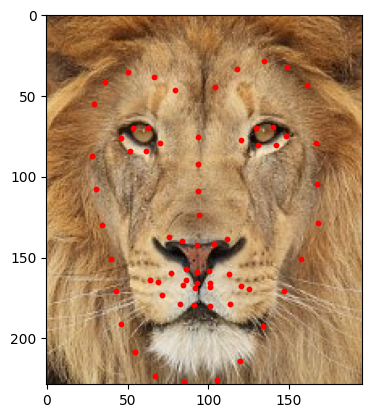

In [46]:
# read image
img_path = "./lion_img.jpg"
img_raw = cv2.imread(img_path)

# get landmarks
coords = get_landmarks_ADNet(img_raw, net, device)

# visualize the landmarks
plt.imshow(img_raw[:, :, [2, 1, 0]])
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], s=10, c='r', marker='o')

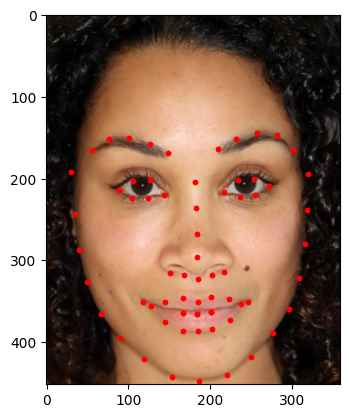

In [47]:
# read image
img_path = "./face_img.jpg"
img_raw = cv2.imread(img_path)

# get landmarks
coords = get_landmarks_ADNet(img_raw, net, device)

# visualize the landmarks
plt.imshow(img_raw[:, :, [2, 1, 0]])
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], s=10, c='r', marker='o')